In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from collections import Counter
from tensorflow.keras import Sequential
import importlib.util
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,MaxPool2D,Softmax,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, callbacks, utils,optimizers


## **Load Data & Exploration & Augmentation**

In [ ]:
Data=ImageDataGenerator()
df=Data.flow_from_directory('cifar10_images')

Found 60000 images belonging to 3 classes.


In [ ]:
df.class_indices

{'test': 0, 'train': 1, 'validation': 2}

In [ ]:
def to_float32(img):
    return img.astype(np.float32)
trainD=ImageDataGenerator(
rescale=1./255,rotation_range=15,
    preprocessing_function=to_float32,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)        # Fill edges with reflection (better than black))
df_train=trainD.flow_from_directory('cifar10_images/train',target_size=(32,32),batch_size=32,class_mode='categorical')


Found 40000 images belonging to 10 classes.


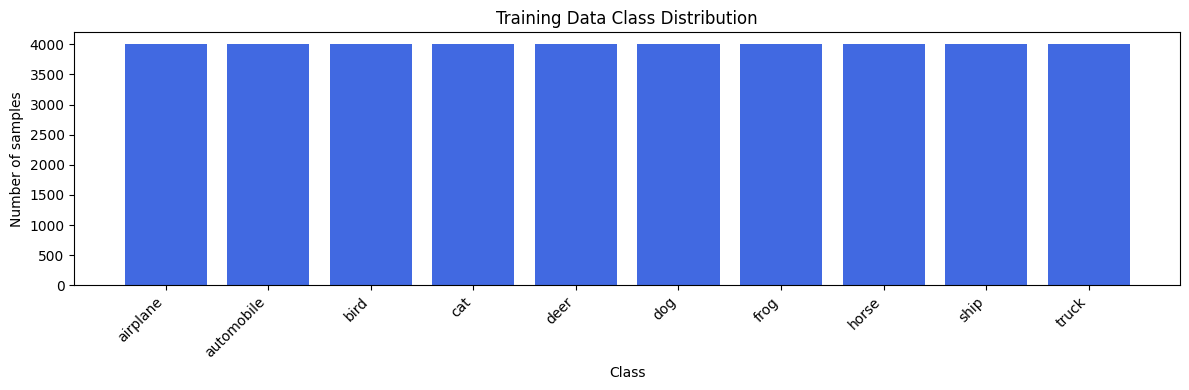

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(df_train.classes)
labels = list(df_train.class_indices.keys())
values = [counts[df_train.class_indices[label]] for label in labels]

plt.figure(figsize=(12,4))
bars = plt.bar(x=labels, height=values, color='royalblue')  # Changed to 'color' parameter
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Training Data Class Distribution')

# Optional: Rotate x-axis labels if they're long
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [ ]:
testD=ImageDataGenerator(rescale=1./255,preprocessing_function=to_float32)
df_test=testD.flow_from_directory('cifar10_images/test',target_size=(32,32),batch_size=32,class_mode='categorical')

Found 10000 images belonging to 10 classes.


In [ ]:
valtD=ImageDataGenerator(rescale=1./255,preprocessing_function=to_float32)
df_val=valtD.flow_from_directory('cifar10_images/validation',target_size=(32,32),batch_size=32,class_mode='categorical')

Found 10000 images belonging to 10 classes.


## **Model Architecture & Prepare Optmizers**

In [ ]:

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        # four hidden layers: 512, 128, 32, 10 nodes
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='relu'),
        # output layer: 10 nodes, softmax
        layers.Dense(10, activation='softmax')
    ])
    return model



In [ ]:
model=create_cnn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [ ]:
from tensorflow_addons.optimizers import AdaBelief
learning_rates = {
    'AdaBelief': 1e-3,
    'Adam': 1e-4,
    'Adam_AMSGrad': 5e-4,
    'SGD': 1e-2,
    'RMSprop': 1e-4,
    'Adagrad': 1e-2
}

optimizers_dict = {
    'AdaBelief': lambda: AdaBelief(learning_rate=learning_rates['AdaBelief']),
    'Adam': lambda: tf.keras.optimizers.Adam(learning_rate=learning_rates['Adam']),
    'Adam_AMSGrad': lambda: tf.keras.optimizers.Adam(learning_rate=learning_rates['Adam_AMSGrad'], amsgrad=True),
    'SGD': lambda: tf.keras.optimizers.SGD(learning_rate=learning_rates['SGD'], momentum=0.9),
    'RMSprop': lambda: tf.keras.optimizers.RMSprop(learning_rate=learning_rates['RMSprop']),
    'Adagrad': lambda: tf.keras.optimizers.Adagrad(learning_rate=learning_rates['Adagrad']),
}

# Training loop
histories = {}
for name, opt_fn in optimizers_dict.items():
    print(f"\nTraining with {name}...")
    model = create_cnn()  # Define your model elsewhere
    model.compile(
        optimizer=opt_fn(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    hist = model.fit(
        df_train,
        epochs=100,
        validation_data=df_val,
        verbose=1
    )
    histories[name] = hist.history


model.save("CIFAR-10.h5")



Training with HN_Adam...
Epoch 1/100
1250/1250 [==============================] - 50s 39ms/step - loss: 1.8790 - accuracy: 0.2786 - val_loss: 1.4759 - val_accuracy: 0.4565
Epoch 2/100
1250/1250 [==============================] - 38s 30ms/step - loss: 1.4183 - accuracy: 0.4815 - val_loss: 1.2891 - val_accuracy: 0.5293
Epoch 3/100
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2434 - accuracy: 0.5531 - val_loss: 1.1263 - val_accuracy: 0.5903
Epoch 4/100
1250/1250 [==============================] - 41s 32ms/step - loss: 1.1338 - accuracy: 0.5933 - val_loss: 1.0515 - val_accuracy: 0.6390
Epoch 5/100
1250/1250 [==============================] - 38s 31ms/step - loss: 1.0566 - accuracy: 0.6267 - val_loss: 0.9202 - val_accuracy: 0.6789
Epoch 6/100
1250/1250 [==============================] - 38s 31ms/step - loss: 0.9846 - accuracy: 0.6542 - val_loss: 0.8992 - val_accuracy: 0.6905
Epoch 7/100
1250/1250 [==============================] - 41s 33ms/step - loss: 0.9349 - accu

In [ ]:
for name in optimizers_dict:
    best_train_acc = max(histories[name]['accuracy'])
    best_train_loss = min(histories[name]['loss'])
    print(f"{name} — Best Train Accuracy: {best_train_acc:.4f}, Best Train Loss: {best_train_loss:.4f}")


HN_Adam — Best Train Accuracy: 0.8840, Best Train Loss: 0.3423
AdaBelief — Best Train Accuracy: 0.8989, Best Train Loss: 0.3062
Adam — Best Train Accuracy: 0.8870, Best Train Loss: 0.3188
Adam_AMSGrad — Best Train Accuracy: 0.9113, Best Train Loss: 0.2529
SGD — Best Train Accuracy: 0.8281, Best Train Loss: 0.5496
RMSprop — Best Train Accuracy: 0.8303, Best Train Loss: 0.4979
Adagrad — Best Train Accuracy: 0.8596, Best Train Loss: 0.3931


## **plotting Evaluations**

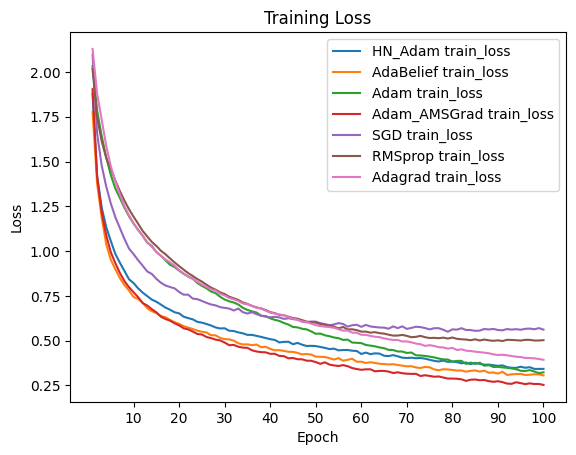

In [ ]:
epochs = np.arange(1, 101)       # 1,2,…,100
xticks = np.arange(10, 101, 10)  # 10,20,…,100
# Plotting Training Loss
plt.figure()
for name, h in histories.items():
    plt.plot(epochs, h['loss'], label=f"{name} train_loss")
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(xticks)
plt.legend()
plt.show()



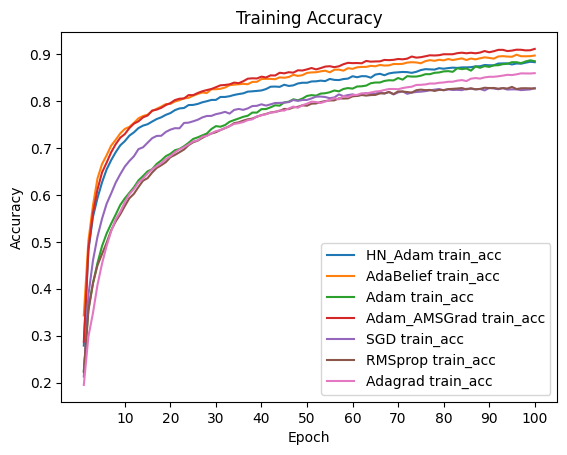

In [ ]:

# Plotting training accuracy
plt.figure()
for name, h in histories.items():
    plt.plot(epochs, h['accuracy'], label=f"{name} train_acc")
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(xticks)
plt.legend()
plt.show()


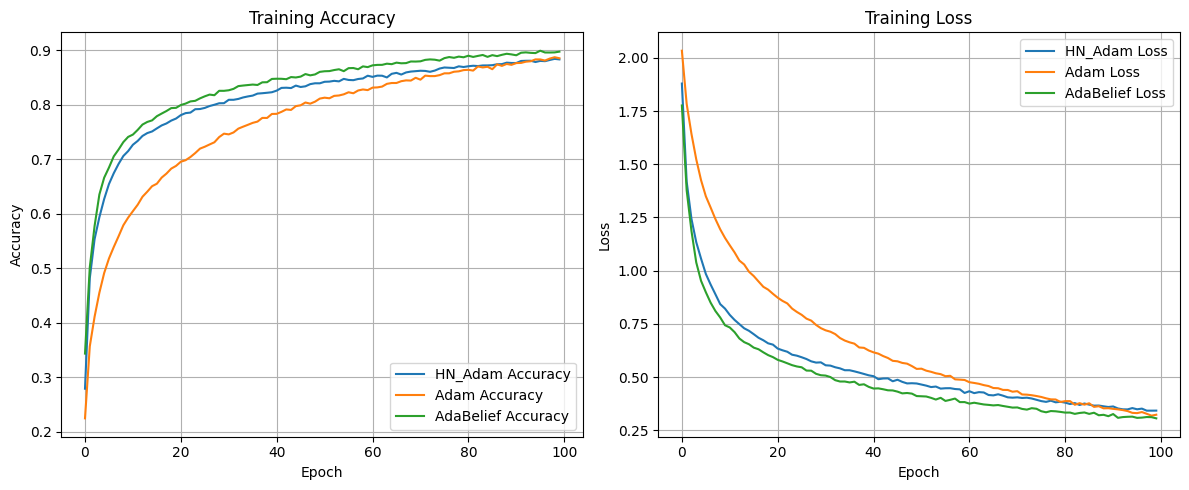

In [ ]:
import matplotlib.pyplot as plt

# Select only the optimizers you care about
selected_optimizers = ['HN_Adam', 'Adam', 'AdaBelief']

# Plot training accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name in selected_optimizers:
    plt.plot(histories[name]['accuracy'], label=f'{name} Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(1, 2, 2)
for name in selected_optimizers:
    plt.plot(histories[name]['loss'], label=f'{name} Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import json

# Save training histories to a JSON file
with open("training_histories.json", "w") as f:
    json.dump(histories, f)
